In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os


In [2]:
# Define base paths
data_dir = "../../data/loaded"
Images_dir = "../../images/process_2"
processed_data_dir = "../../data/processed"
climate_file_path = os.path.join(data_dir, "climate.csv")

In [3]:
clim_df = pd.read_csv(climate_file_path)

In [4]:
clim_df.head()

,time,lat,lon,prec,tmin,tmax
0,1,37.291667,9.541667,48.075,8.50,16.50
1,1,37.291667,9.625000,45.525,8.25,16.75
2,1,37.291667,9.708333,42.900,8.25,16.75
3,1,37.291667,9.791667,40.975,8.25,17.00
4,1,37.208333,9.208333,54.350,9.00,17.00


In [6]:
clim_df.describe()

,time,lat,lon,prec,tmin,tmax
count,395124.000000,395124.000000,395124.000000,395124.000000,395124.000000,395124.000000
mean,6.500000,28.565849,3.108228,5.298888,16.838228,31.358228
std,3.452057,4.405626,4.543884,11.136617,8.055408,8.543038
min,1.000000,19.041667,-8.625000,0.000000,-2.250000,5.250000
25%,3.750000,25.125000,-0.125000,0.800000,10.000000,24.250000
50%,6.500000,28.375000,3.458333,1.725000,17.000000,32.000000
75%,9.250000,32.125000,6.791667,4.475000,24.000000,38.250000
max,12.000000,37.291667,11.958333,266.150000,32.000000,48.000000


# get stats of each location

## 1- assign seasons

In [7]:
def assign_season(month):
    if month in (12, 1, 2):
        return "winter"
    elif month in (3, 4, 5):
        return "spring"
    elif month in (6, 7, 8):
        return "summer"
    else:
        return "autumn"

def add_season_column(df):
    df = df.copy()
    df['season'] = df['time'].apply(assign_season)
    return df

In [8]:
new_clim = add_season_column(clim_df)

## 2- median

In [10]:
def compute_seasonal_medians(df):
    medians = df.groupby(['lon','lat','season']).agg({
        'prec': 'median',
        'tmin': 'median',
        'tmax': 'median'
    }).unstack('season')

    # Flatten MultiIndex columns
    medians.columns = [
        f"{var}_median_{season}" 
        for var, season in medians.columns
    ]
    return medians


In [11]:
med = compute_seasonal_medians(new_clim)

## 3- IQR

In [12]:
def compute_seasonal_iqr(df):
    def iqr(x):
        return x.quantile(0.75) - x.quantile(0.25)

    iqr_df = df.groupby(['lon','lat','season']).agg({
        'prec': iqr,
        'tmin': iqr,
        'tmax': iqr
    }).unstack('season')

    iqr_df.columns = [
        f"{var}_iqr_{season}"
        for var, season in iqr_df.columns
    ]
    return iqr_df


In [13]:
iqr = compute_seasonal_iqr(new_clim)

## 4- extreme values

In [14]:
def compute_extremes(df):
    extremes = df.groupby(['lon','lat']).agg({
        'tmax': 'max',
        'prec': 'min'
    })

    extremes.rename(columns={
        'tmax': 'tmax_max',
        'prec': 'prec_min'
    }, inplace=True)

    return extremes


In [15]:
extremes = compute_extremes(new_clim)

## 5- Persistence

In [21]:
def longest_streak(values, condition):
    streak = max_streak = 0
    for v in values:
        if condition(v):
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak


def collect_monthly_lists(df):
    # ensure chronological order
    df = df.sort_values(['lon', 'lat', 'time'])

    return df.groupby(['lon','lat']).agg({
        'prec': list,
        'tmax': list
    }).rename(columns={'prec':'prec_list','tmax':'tmax_list'})


def compute_persistence_features(monthly_df, dry_thresh=0.5, hot_thresh=38):
    out = {}

    for idx, row in monthly_df.iterrows():
        
        dry_streak = longest_streak(row.prec_list, lambda x: x < dry_thresh)
        hot_streak = longest_streak(row.tmax_list, lambda x: x > hot_thresh)

        out[idx] = {
            'longest_dry_period': dry_streak,
            'longest_hot_period': hot_streak
        }

    return pd.DataFrame.from_dict(out, orient='index')


In [22]:
monthly = collect_monthly_lists(new_clim)
pers = compute_persistence_features(monthly)

## Final

In [23]:
 # merge all
final_clim = med.join([iqr, extremes, pers], how='left')

In [24]:
final_clim.reset_index(inplace=True)

In [25]:
final_clim.head()

,lon,lat,prec_median_autumn,prec_median_spring,prec_median_summer,prec_median_winter,tmin_median_autumn,tmin_median_spring,tmin_median_summer,tmin_median_winter,...,tmin_iqr_summer,tmin_iqr_winter,tmax_iqr_autumn,tmax_iqr_spring,tmax_iqr_summer,tmax_iqr_winter,tmax_max,prec_min,longest_dry_period,longest_hot_period
0,-8.625,27.291667,7.150,0.50,1.3,2.000,18.0,18.0,27.00,8.0,...,2.125,1.500,4.5,3.125,2.750,1.625,41.75,0.0,2,2
1,-8.625,27.375000,7.900,0.50,1.3,2.150,18.0,18.0,27.00,8.5,...,2.500,1.500,4.5,3.000,2.625,1.875,41.25,0.0,2,2
2,-8.625,27.458333,8.125,0.50,1.3,2.900,18.0,17.5,27.00,8.5,...,2.500,1.500,4.5,3.000,2.750,1.750,41.50,0.0,2,2
3,-8.625,27.541667,8.100,0.45,1.3,2.825,18.0,17.0,26.75,8.0,...,2.500,1.375,4.5,3.000,2.500,1.500,41.00,0.0,2,2
4,-8.625,27.625000,8.100,0.40,1.3,2.800,18.0,17.0,26.25,8.0,...,2.500,1.000,5.0,3.000,2.500,1.500,41.00,0.0,2,2


In [26]:
# number of lon/lat combinations
final_clim.shape

(32927, 30)

In [27]:
final_clim.describe()

,lon,lat,prec_median_autumn,prec_median_spring,prec_median_summer,prec_median_winter,tmin_median_autumn,tmin_median_spring,tmin_median_summer,tmin_median_winter,...,tmin_iqr_summer,tmin_iqr_winter,tmax_iqr_autumn,tmax_iqr_spring,tmax_iqr_summer,tmax_iqr_winter,tmax_max,prec_min,longest_dry_period,longest_hot_period
count,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,...,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000,32927.000000
mean,3.108228,28.565849,6.254657,4.388939,2.127052,6.297596,18.808073,16.349187,26.494080,6.432396,...,1.178888,1.465715,5.212257,4.333575,1.475877,1.522122,42.261973,0.292129,1.507213,3.030795
std,4.543947,4.405687,9.204427,6.977836,2.527860,15.551316,3.023662,3.668846,2.906042,2.130701,...,0.687861,0.485790,0.670986,0.623731,0.589328,0.423025,3.450184,0.411355,1.556134,1.709128
min,-8.625000,19.041667,0.000000,0.000000,0.000000,0.000000,8.250000,3.750000,13.500000,-1.250000,...,0.000000,0.000000,2.500000,2.166667,0.500000,0.000000,29.000000,0.000000,0.000000,0.000000
25%,-0.125000,25.125000,1.100000,0.725000,0.500000,0.800000,17.000000,15.000000,25.000000,5.000000,...,0.500000,1.000000,5.000000,4.000000,1.000000,1.250000,40.000000,0.000000,0.000000,2.000000
50%,3.458333,28.375000,1.950000,1.725000,1.000000,1.550000,19.000000,17.000000,27.000000,6.000000,...,1.000000,1.500000,5.375000,4.500000,1.500000,1.500000,43.000000,0.000000,1.000000,3.000000
75%,6.791667,32.125000,6.975000,4.150000,2.900000,3.725000,20.750000,19.000000,29.000000,8.000000,...,1.750000,1.875000,5.500000,4.875000,2.000000,1.875000,45.000000,0.600000,2.000000,5.000000
max,11.958333,37.291667,69.200000,47.150000,17.450000,217.125000,25.250000,24.000000,31.000000,12.000000,...,3.000000,3.000000,7.000000,6.000000,3.250000,3.000000,48.000000,2.150000,9.000000,7.000000


# Viz

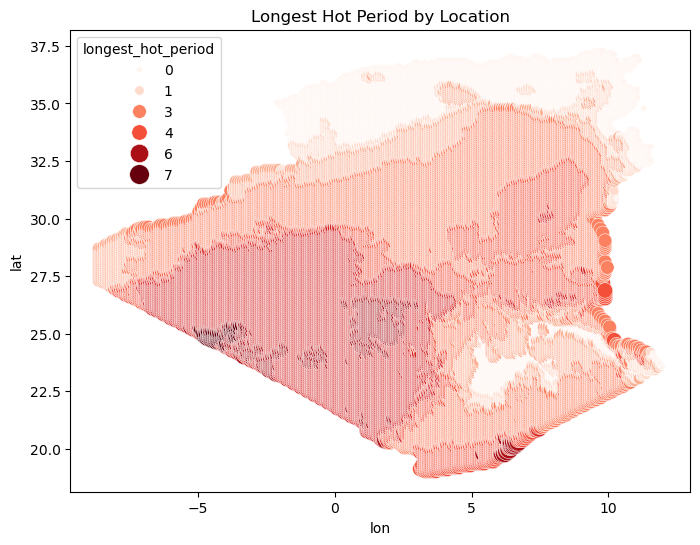

In [28]:
# scatter plot of longest_hot_period for each lon/lat
plt.figure(figsize=(8,6))
sns.scatterplot(data=final_clim, x='lon', y='lat', size='longest_hot_period', hue='longest_hot_period', palette='Reds', sizes=(20, 200))
plt.title('Longest Hot Period by Location')
plt.savefig(os.path.join(Images_dir, "longest_hot_period_scatter.png"))
plt.show()

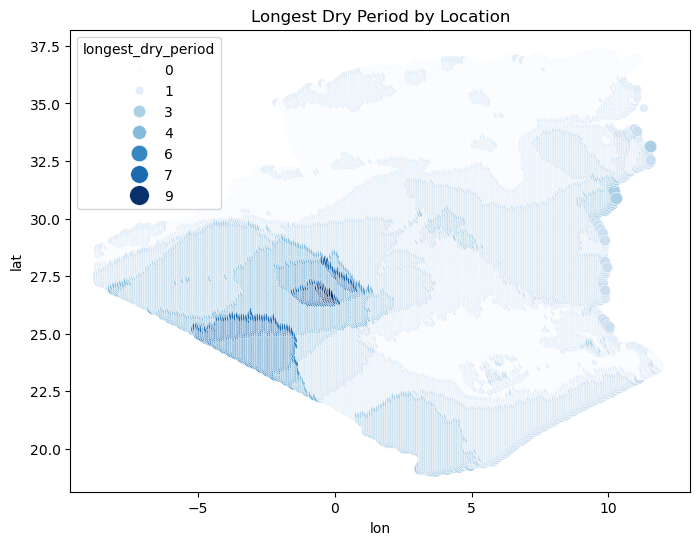

In [29]:
# scatter of longest dry period
plt.figure(figsize=(8,6))
sns.scatterplot(data=final_clim, x='lon', y='lat', size='longest_dry_period', hue='longest_dry_period', palette='Blues', sizes=(20, 200))
plt.title('Longest Dry Period by Location')
plt.savefig(os.path.join(Images_dir, "longest_dry_period_scatter.png"))
plt.show()

# save

In [30]:
# save
final_clim.to_csv(os.path.join(processed_data_dir, "processed_climate.csv"), index=False)